This is main supported by MONAI lib.



# Brain tumor 2D segmentation with MONAI

This tutorial shows how to construct a training workflow of multi-labels segmentation task.

And it contains below features:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms to accelerate training and validation.
1. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Deterministic training for reproducibility.

The dataset comes from http://medicaldecathlon.com/.
Target: Gliomas segmentation necrotic/active tumour and oedema
Modality: Multimodal multisite MRI data (FLAIR, T1w, T1gd,T2w)
Size: 750 4D volumes (484 Training + 266 Testing)
Source: BRATS 2016 and 2017 datasets.
Challenge: Complex and heterogeneously-located targets

Below figure shows image patches with the tumor sub-regions that are annotated in the different modalities (top left) and the final labels for the whole dataset (right).
(Figure taken from the [BraTS IEEE TMI paper](https://ieeexplore.ieee.org/document/6975210/))

![image](https://raw.githubusercontent.com/Project-MONAI/tutorials/refs/heads/main/figures/brats_tasks.png)

The image patches show from left to right:
1. the whole tumor (yellow) visible in T2-FLAIR (Fig.A).
1. the tumor core (red) visible in T2 (Fig.B).
1. the enhancing tumor structures (light blue) visible in T1Gd, surrounding the cystic/necrotic components of the core (green) (Fig. C).
1. The segmentations are combined to generate the final labels of the tumor sub-regions (Fig.D): edema (yellow), non-enhancing solid core (red), necrotic/cystic core (green), enhancing core (blue).


## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import seaborn" || pip install -q seaborn

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.2 MB/s eta 0:00

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu113
!pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu113


In [3]:
!pip install mlflow pynrrd clearml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 10.5 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 52.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.2/676.2 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 9.7 MB/s eta 0:00:00



## Setup imports

In [4]:
import os
import tempfile
import time
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import torch, monai
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch import GradScaler, autocast
from tqdm import tqdm

from monai.inferers import DiffusionInferer
from monai.networks.nets import DiffusionModelUNet
from monai.networks.schedulers import DDPMScheduler
from monai.metrics import DiceMetric

torch.multiprocessing.set_sharing_strategy("file_system")
print_config()

2025-07-18 21:12:31.689238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752873151.922822      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752873151.989186      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.6.dev2528
Numpy version: 1.26.4
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7c86eeeae01528647a5703f2fd5df9bc10a8536f
MONAI __file__: /usr/local/lib/python3.11/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.15.3
Pillow version: 11.2.1
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: 4.52.4
mlflow version: 3.1.1
pynrrd version: 1.1.3
clearml version: 2.0.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set deterministic training for reproducibility

In [5]:
set_determinism(42)


## Preprocessing of the BRATS Dataset in 2D slices for training
We download the BRATS training dataset from the Decathlon dataset.


In [6]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"


train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        
        # Add Random Flip and Rotate
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        transforms.RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3, spatial_axes=(0, 1)),

        transforms.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
    ]
)

In [7]:
!ls /kaggle/input/

In [9]:
batch_size = 32

root_dir = "/kaggle/working/task01-braintumour" 
os.makedirs(root_dir, exist_ok=True)

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=1.0,  # TODO: you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)

print(f"Length of training data: {len(train_ds)}")  # this gives the number of patients in the training set
print(f'Train image shape {train_ds[0]["image"].shape}')
print(f'Train label shape {train_ds[0]["label"].shape}')


train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)

Task01_BrainTumour.tar: 7.09GB [08:27, 15.0MB/s]                                


2025-07-18 21:22:00,397 - INFO - Downloaded: /kaggle/working/task01-braintumour/Task01_BrainTumour.tar
2025-07-18 21:22:17,456 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-07-18 21:22:17,457 - INFO - Writing into directory: /kaggle/working/task01-braintumour.


Loading dataset: 100%|██████████| 388/388 [05:52<00:00,  1.10it/s]

Length of training data: 388
Train image shape torch.Size([1, 64, 64])
Train label shape torch.Size([1, 64, 64])


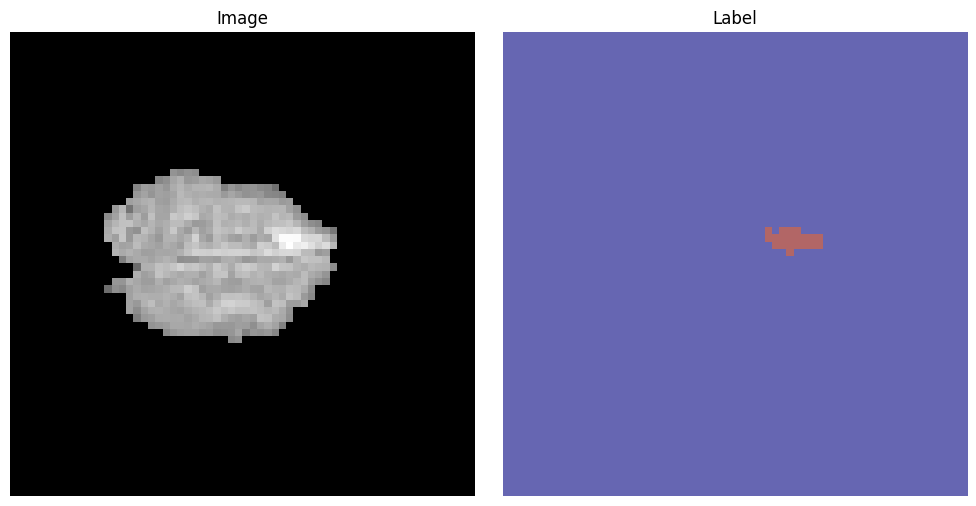

In [10]:
from matplotlib import cm
def plot_image_and_label(image_tensor, label_tensor, slice_index=None):
    """
    image_tensor: shape [1, H, W] — typically C=1
    label_tensor: shape [1, H, W]
    """
    image_np = image_tensor[0].cpu().numpy()  # Remove channel
    label_np = label_tensor[0].cpu().numpy()


    plt.figure(figsize=(10, 5))

    # 图像
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, cmap="gray")
    plt.title(f"Image")
    plt.axis("off")

    # 标签（掩码）
    plt.subplot(1, 2, 2)
    plt.imshow(label_np, cmap="jet", alpha=0.6)
    plt.title(f"Label")
    plt.axis("off")


    # masked_label = np.ma.masked_where(label_np == 0, label_np)
    # cmap = cm.get_cmap("jet")
    # # cmap.set_bad(color="white")  # Set background color
    # plt.imshow(masked_label, cmap=cmap)
    # plt.title("Label")
    # plt.axis("off")


    plt.tight_layout()
    plt.show()

# 示例：可视化第一个病人的数据
sample = train_ds[36]
plot_image_and_label(sample["image"], sample["label"])

## Preprocessing of the BRATS Dataset in 2D slices for validation
We download the BRATS validation dataset from the Decathlon dataset. We define the dataloader to load 2D slices as well as the corresponding ground truth tumor segmentation for validation.

In [27]:
test_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),


        transforms.Lambdad(
            keys=["image", "label"],
            func=lambda x: x[..., x.shape[-1] // 2]  # Take center Z slice (output shape: (C, Y, X))
        ),

        transforms.CenterSpatialCropd(
            keys=["image", "label"],
            roi_size=(64, 64)
        ),

        
        # transforms.RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(64, 64, 64),
        #     pos=1,            # probability of sampling foreground
        #     neg=0,            # probability of sampling background
        #     num_samples=4,    # number of crops per input
        #     image_key="image"
        # ),
            
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        # transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        
        
        # Add Random Flip and Rotate

        transforms.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
    ]
)

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=test_transforms,
)


val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)

Loading dataset: 100%|██████████| 96/96 [01:40<00:00,  1.05s/it]


In [29]:
print(f"Length of training data: {len(val_ds)}")
# print(val_ds[0])
print(f'Validation Image shape {val_ds[0]["image"].shape}')
print(f'Validation Label shape {val_ds[0]["label"].shape}')

Length of training data: 96
Validation Image shape torch.Size([1, 64, 64])
Validation Label shape torch.Size([1, 64, 64])


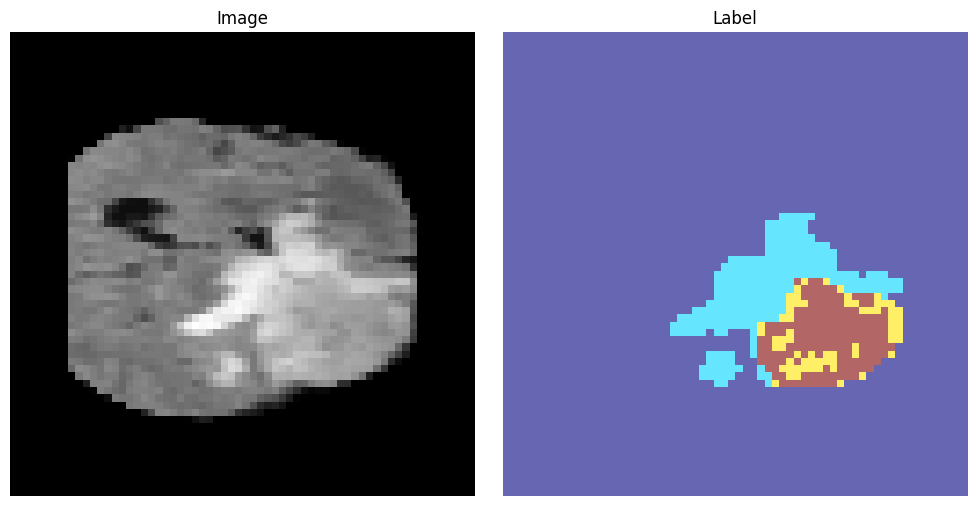

In [30]:
sample = val_ds[0]
plot_image_and_label(sample["image"], sample["label"])


## Define network, scheduler, optimizer, and inferer

At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using the DDPM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms in the 3rd level (`num_head_channels=64`).<br>


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

In [22]:
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

## Model training of the Diffusion Model<br>
We train our diffusion model for 4000 epochs.\
In every step, we concatenate the original MR image to the noisy segmentation mask, to predict a slightly denoised segmentation mask.\
This is described in Equation 7 of the paper https://arxiv.org/pdf/2112.03145.pdf.

Epoch 1/2: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s, loss=0.917]


Epoch 0 Validation Dice =  0.0468357615172863


Epoch 2/2: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s, loss=0.899]


Epoch 1 Validation Dice =  0.05414223670959473
train diffusion completed, total time: 40.33795523643494.


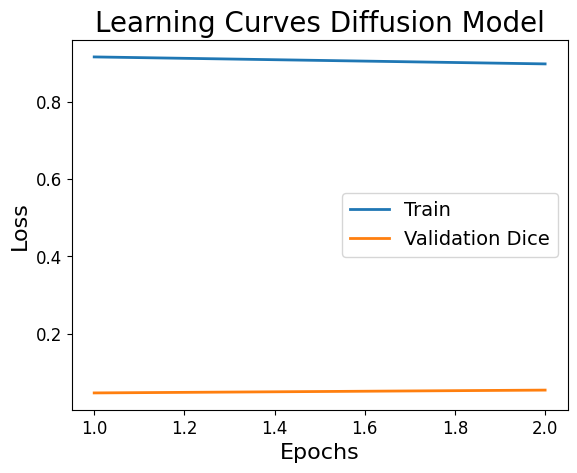

In [24]:
from tqdm import tqdm

max_epochs   = 500  # 
val_interval = 20
epoch_loss_list = []
val_epoch_loss_list = []
metric_values = []


scaler = GradScaler("cuda")
total_start = time.time()

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)

for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{max_epochs}")
    
    for _step, data in progress_bar:
        images = data["image"].to(device)
        seg    = data["label"].to(device)  # this is the ground truth segmentation
        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=True):
            # Generate random noise
            optimizer.zero_grad()
            outputs = model(images)
            loss    = loss_function(outputs, seg)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=epoch_loss / (_step + 1))
        

    epoch_loss_list.append(epoch_loss / (_step + 1))
    if (epoch) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for _step, data_val in enumerate(val_loader):
            images = data_val["image"].to(device)
            seg    = data_val["label"].to(device)  # this is the ground truth segmentation
            with torch.no_grad(), autocast("cuda", enabled=True):
                val_outputs = model(images)
            val_outputs = torch.softmax(val_outputs, dim=1) 
            dice_metric(y_pred=val_outputs, y=seg)

        metric = dice_metric.aggregate().item()
        # reset the status for next validation round
        dice_metric.reset()
        metric_values.append(metric)
        print("Epoch", epoch, "Validation Dice = ", metric)
    

torch.save(model.state_dict(), "./segmodel.pt")
total_time = time.time() - total_start
print(f"train diffusion completed, total time: {total_time}.")

plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    metric_values,
    color="C1",
    linewidth=2.0,
    label="Validation Dice",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

##  transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        
        # Add Random Flip and Rotate
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        transforms.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        transforms.RandRotate90d(keys=["image", "label"], prob=0.5, max_k=3, spatial_axes=(0, 1)),Sampling of segmentation mask for input image of the validation set<br>


In [25]:
import torch
from torch.cuda.amp import autocast
from monai.metrics import DiceMetric
from monai.transforms import Activations

# Make sure your model is in eval mode
model.eval()

# Reset metric
dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric.reset()

# List to store outputs (e.g., for visualization or further evaluation)
all_predictions = []

# Optional: Use MONAI's activation wrapper for clean postprocessing
activation = Activations(softmax=True)

with torch.no_grad():
    for _step, data_val in tqdm(enumerate(val_loader)):
        images = data_val["image"].to(device)
        seg = data_val["label"].to(device)  # ground truth

        with autocast("cuda"):
            val_outputs = model(images)

        # Apply softmax activation (for multi-class)
        val_outputs = activation(val_outputs)

        # Save prediction (detach + move to CPU to avoid memory issues)
        all_predictions.append(val_outputs.detach().cpu())

        # Compute Dice
        dice_metric(y_pred=val_outputs, y=seg)

# Aggregate final Dice score
mean_dice = dice_metric.aggregate().item()
print(f"Validation Dice: {mean_dice:.4f}")


all_predictions = np.concatenate(all_predictions, axis=0)
print("all_predictions size=", all_predictions.shape)


3it [00:10,  3.64s/it]

Validation Dice: 0.0000
all_predictions size= (384, 1, 64, 64)
